# Jane Street Market Prediction 🎯
> Jane Street Market Prediction Kaggle Competition

- toc: true 
- badges: true
- comments: true
- author: Jaekang Lee
- categories: [MLP, python, feature engineering, imputation, Jane Street, Kaggle, Visualization, Big Data, random forest]

Got a score of 9443.499 (249th place out of 3616 competitors) using MLP.

### Library 📂

In [1]:
#hide_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from random import choices
!pip install datatable > /dev/null
import datatable as dt
from sklearn import impute
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

/kaggle/input/data-wrangling/__results__.html
/kaggle/input/data-wrangling/__notebook_source__.ipynb
/kaggle/input/data-wrangling/imputed.csv
/kaggle/input/data-wrangling/__notebook__.ipynb
/kaggle/input/data-wrangling/__output__.json
/kaggle/input/data-wrangling/one_on_top.csv
/kaggle/input/data-wrangling/custom.css
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/janestreetimputeddata/negative_knn_1.csv
/kaggle/input/janestreetimputeddata/negative_forward_backward.csv
/kaggle/input/janestreetimputeddata/negative_target.csv
/kaggle/input/janestreetimputeddata/negative_iterative_impute.csv
/kaggle/input/janestreetim

## Methodology


### Null Values 🈳

As discussed before in my [EDA notebook](https://leejaeka.github.io/jaekangai/python/eda/jane%20street/kaggle/visualization/big%20data/2021/01/23/JaneStreet-Copy1.html), we have couple of options to handle null values. <br>
1. Drop all nans
2. Impute with median or mean
3. Feedforward/backward
4. KNN imputer
5. Be creative! 
<br>

In this notebook, I used KNN imputer with 5 nearest neighbors to fill the nans. This takes a long time to run so I suggest downloading the imputed data files from [here](https://www.kaggle.com/louise2001/janestreetimputeddata) by louise2001. Note that he also uploaded soft and iterative imputes.

In [ ]:
#hide_input
df = df.set_index('ts_id', drop=True)
df.drop(columns=[f"resp_{i}" for i in range(1, 5)], inplace=True)
print(f'Done loading data. df shape is {df.shape}')
TARGET = 'resp'
FEATURES = [f"feature_{i}" for i in range(1, 130)]
train_pos, train_neg = df.loc[df.feature_0 > 0], df.loc[df.feature_0 < 0]
train_pos.drop(columns=[TARGET, 'feature_0'], inplace=True)
train_neg.drop(columns=[TARGET, 'feature_0'], inplace=True)
gc.collect()
nan_neg = pd.read_csv("../input/janestreetimputeddata/nan_neg.csv", header=None, sep=' ').values.astype(int)
nan_pos = pd.read_csv("../input/janestreetimputeddata/nan_pos.csv", header=None, sep=' ').values.astype(int)

# Split into X and y
from copy import deepcopy as dc
X_pos = dc(train_pos[FEATURES].values)
X_neg = dc(train_neg[FEATURES].values)
del train_pos, train_neg
gc.collect()

# load files 
file = 'knn_5'
path = "../input/janestreetimputeddata/"
X_pos[nan_pos[0], nan_pos[1]] = pd.read_csv(path+f"positive_{file}.csv", 
                                            header=None, sep=' ').values.flatten()
X_neg[nan_neg[0], nan_neg[1]] = pd.read_csv(path+f"negative_{file}.csv",                                         
                                            header=None, sep=' ').values.flatten()

df = np.concatenate((X_pos, X_neg), axis=0)
del X_pos, X_neg, nan_neg, nan_pos
gc.collect()

df = pd.DataFrame(df, columns = FEATURES)

In [ ]:
#hide_input
train = dt.fread('../input/jane-street-market-prediction/train.csv')
train = train.to_pandas()
train = train[['date', 'weight', 'ts_id', 'resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4','feature_0']]
gc.collect()

# split train into 1s and 0s 
upper = train[train['feature_0'] == 1].sort_values(by='ts_id', axis=0, ascending=True)
lower = train[train['feature_0'] == -1].sort_values(by='ts_id', axis=0, ascending=True)

# attach
train = pd.concat([upper, lower], axis = 0)
del upper, lower
gc.collect()

# save files
df.to_csv('imputed.csv', index=False)
train.to_csv('one_on_top.csv', index=False)
gc.collect()

### Import Data 📚

In this notebook, we are just going to load the imputed data instead of running the feature engineering here. Since it is very time consuming and takes a lot of RAM.

In [42]:
#hide_output
imputed_df = dt.fread('../input/data-wrangling/imputed.csv')
imputed_df = imputed_df.to_pandas()
train = dt.fread('../input/data-wrangling/one_on_top.csv')
train = train.to_pandas()

df = pd.concat([train, imputed_df], axis=1, ignore_index=False)
del train, imputed_df
gc.collect()

3815

In [5]:
#hide_input
df.head(5)

date    weight  ts_id    resp_1    resp_2    resp_3      resp    resp_4  \
0     0  0.000000      0  0.009916  0.014079  0.008773  0.006270  0.001390   
1     0  0.138531      4  0.001252  0.002165 -0.001215 -0.002604 -0.006219   
2     0  0.116557      8 -0.005460 -0.007301 -0.009085 -0.001677 -0.003546   
3     0  0.160117      9  0.005976  0.004345  0.023712  0.020317  0.035360   
4     0  0.109651     10  0.006899  0.003405  0.000134 -0.000690 -0.003040   

   feature_0  feature_1  ...  feature_120  feature_121  feature_122  \
0          1  -1.872746  ...     0.603878     6.086305     1.168391   
1          1  -3.172026  ...     0.745019     5.354213     0.344850   
2          1  -3.172026  ...     1.120067     4.167835     1.537913   
3          1   2.744408  ...     1.430190     3.332330     1.796860   
4          1  -3.172026  ...     1.581096     6.305170     2.324290   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292   
1     4.101145     0.614252     6.623456     0.800129     5.233243   
2     4.785838     1.637435     6.968002     2.354338     5.825499   
3     3.177064     0.999252     2.906432     1.589816     2.435999   
4     4.881133     2.115830     6.337250     3.059392     5.350729   

   feature_128  feature_129  
0     2.301488    11.445807  
1     0.362636     3.926633  
2     1.778029     4.740577  
3     1.472419     2.245991  
4     2.755876     4.968388  

[5 rows x 138 columns]

### Feature Engineering 🔧

We first do two feature engineering right off the bat.
1. We are going to drop any rows with 'weight' column equal to 0. This tells us that overall gain from such trade is 0. This would be like telling machine to just guess if learned correctly. <br>
2. To explain why we are dropping all dates before day 85 can be shown visually below. Before the day 85, we can clearly see that the trend has changed quite drastically. 

7310

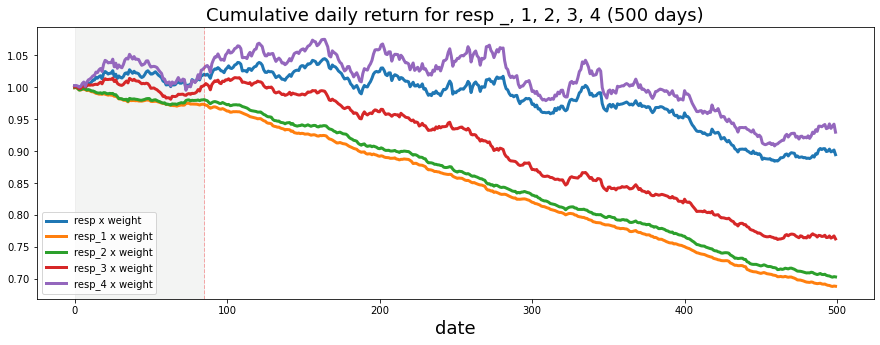

In [43]:
#hide_input
df['weight_resp']   = df['weight']*df['resp']
df['weight_resp_1'] = df['weight']*df['resp_1']
df['weight_resp_2'] = df['weight']*df['resp_2']
df['weight_resp_3'] = df['weight']*df['resp_3']
df['weight_resp_4'] = df['weight']*df['resp_4']

fig, ax = plt.subplots(figsize=(15, 5))
resp    = pd.Series(1+(df.groupby('date')['weight_resp'].mean())).cumprod()
resp_1  = pd.Series(1+(df.groupby('date')['weight_resp_1'].mean())).cumprod()
resp_2  = pd.Series(1+(df.groupby('date')['weight_resp_2'].mean())).cumprod()
resp_3  = pd.Series(1+(df.groupby('date')['weight_resp_3'].mean())).cumprod()
resp_4  = pd.Series(1+(df.groupby('date')['weight_resp_4'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return for resp _, 1, 2, 3, 4 (500 days)", fontsize=18)
resp.plot(lw=3, label='resp x weight')
resp_1.plot(lw=3, label='resp_1 x weight')
resp_2.plot(lw=3, label='resp_2 x weight')
resp_3.plot(lw=3, label='resp_3 x weight')
resp_4.plot(lw=3, label='resp_4 x weight')
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.legend(loc="lower left");

del df['weight_resp'], df['weight_resp_1'], df['weight_resp_2'],df['weight_resp_3'],df['weight_resp_4']
del resp, resp_1, resp_2, resp_3, resp_4
gc.collect()

In [6]:
df = df.query('date > 85').reset_index(drop = True) 
df = df[df['weight'] != 0]

Note that we only have 130 features compared to over 2 million datas. We easily make more features and avoid curse of dimensionality. 

In [7]:
#hide_output
# Add action column (this is our target)
df['action'] = ((df['resp'].values) > 0).astype(int)

# feature names
features = [c for c in df.columns if "feature" in c]
# resp names
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

(1571415, 139)

In [8]:
# We don't need time, date and weight anymore
df = df.loc[:, df.columns.str.contains('feature|resp', regex=True)]

Let us do log transform and add them as new columns to the dataframe. Since performing on all features will give me out of memory error, let's do this on group_0 which has tag_0 from features.csv. For more information, check out my [EDA notebook](https://leejaeka.github.io/jaekangai/python/eda/jane%20street/kaggle/visualization/big%20data/2021/01/23/JaneStreet-Copy1.html).

In [9]:
# Get log transformation for tag groups
tag_0_group = [9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, 123]
for col in tag_0_group:
    df[str('log_'+str(col))] = (df[str('feature_'+str(col))]-df[str('feature_'+str(col))].min()+1).transform(np.log)

In [15]:
#hide_input
df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          1   3.151305   5.467693  -0.164505  -0.189219   0.663966   
2          1   1.514607   0.596214   0.324062   0.154730   0.845069   
4          1  -0.833827  -0.049648   0.262484   0.421901   0.098124   
5          1  -3.172026  -3.093182   0.155047   0.343024   0.451619   
6          1  -3.172026  -3.093182   0.188790   0.232964   0.500087   

   feature_6  feature_7  feature_8  feature_9  ...    log_73    log_79  \
0   0.988896   0.661407   0.897346   2.184804  ...  4.371497  4.954968   
2   0.521491   0.860309   0.595352   0.310387  ...  4.385074  4.956836   
4   0.171741   0.034455   0.169169   0.512029  ...  4.373749  4.934122   
5   0.914937  -0.596771  -0.827370  -0.974472  ...  4.395633  4.958532   
6   0.639725  -0.083674   0.019814  -4.050318  ...  4.390247  4.959537   

         log_85        log_91        log_97       log_103   log_109   log_115  \
0  1.009198e-07  1.235292e-07  1.372731e+00  7.735990e-01  1.583237  0.994426   
2  1.009198e-07  1.235292e-07  7.875868e-01  5.235099e-01  0.793093  0.487668   
4  6.493667e-01  8.441718e-01  1.314139e+00  1.969321e+00  1.542457  2.065858   
5  1.072512e+00  7.936777e-01  1.070915e-07  7.520313e-08  1.298665  0.488986   
6  8.272507e-01  1.036085e+00  6.587185e-01  4.546515e-01  1.000972  1.028346   

    log_122   log_123  
0  2.206237  2.390646  
2  2.191892  2.100277  
4  1.813171  2.373700  
5  1.943198  2.112894  
6  1.824567  2.101414  

[5 rows x 147 columns]

Other ideas for feature engineering:
1. aggregating categorical columns by 'tags' on features.csv
2. count above mean, mean abs change, abs energy
3. log transform, kurt transform and other transforms
4. get creative!

Reasons not to do more feature engineering:
1. We have no idea what the features represent so it might be meaningless and dangerous
2. The dataset is really big so adding couple more columns will make me run out of memory
3. Much slower computation

### Split data ✂️

We are going to use approximately 20000 data as test set. Our target value is action which we already have defined as any weight times resp above 0.(positive trades)

In [10]:
#hide_output
# Train test split
from sklearn.model_selection import train_test_split
X = df.loc[:, df.columns.str.contains('feature|log')]
y = np.stack([(df[c] > 0).astype('int') for c in resp_cols]).T
del df
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=True)


del X, y
gc.collect()

0

### Implementation #2
#### Algoritms & Technique
For technique, we already applied a lot of our knowledge from our EDA into our dataset. (Feature engineering, imputing nulls, dropping < 85 days, etc). For algorithm, we are going to use machine learning. <br>
Now we have our data ready for training. There are hundreds of classifier model we can choose from and explore. However, after studying the Kaggle notebooks other participants have submitted, all high scored model seem to use Neural Network. I am going to try using random forest classifier and MLP to experiment here. Random Forest are always good for early because it is easy to just build and evaluate. Neural network is good at learning complicated models with the right parameter tuning. <br>
#### Metrics
Since this is a multiclass-classifying problem (5 types of 'resp' -> gave us 5 pos vs neg target variables), for performance metrics we are going to use AUC(area under curve) as well as pure accuracy score for overall performance. With this metrics, we can see how our model is performing on unseen data and prevent overfitting easily to see any area for improvement accordingly. Sklearn and Seaborn provides great graphing tools for these metrics as well.
#### Complications
Note that the worst complication I had to face going through rest of this notebook was the size of the data. Depending on your computer's RAM size and GPU computation speed this experience will vary. In my case, I ran into out of memory a hundreds of times. To avoid this, try using cloud training. If not make sure to save your computed data frequently and clean RAM with gc.collect and del function to free up space as much as possible. 


## Results

### Random Forest Classifier evaluation and validation

In [11]:
#hide_output
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32, n_jobs=-1, verbose=2)
rnd_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.8min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.3min finished


RandomForestClassifier(max_leaf_nodes=32, n_jobs=-1, verbose=2)

In [12]:
test_pred = rnd_clf.predict(X_test)
test_pred = np.rint(test_pred)
test_acc = np.sum(test_pred == y_test)/(y_test.shape[0]*5)
print("test accuracy: " + str(test_acc))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s


test accuracy: 0.5242761692650334


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


resp
[[3474 4349]
 [3205 4687]]
resp_1
[[4261 3487]
 [3768 4199]]
resp_2
[[3740 4001]
 [3367 4607]]
resp_3
[[2823 4959]
 [2643 5290]]
resp_4
[[3003 4858]
 [2743 5111]]


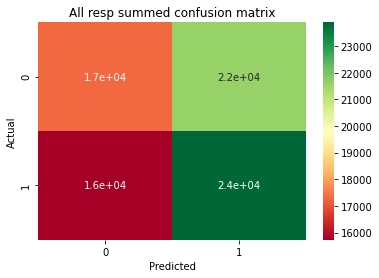

In [41]:
#hide_input
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test[:,3], test_pred[:,3])
resp_1 = confusion_matrix(y_test[:,0], test_pred[:,0])
resp_2 = confusion_matrix(y_test[:,1], test_pred[:,1])
resp_3 = confusion_matrix(y_test[:,2], test_pred[:,2])
resp_4 = confusion_matrix(y_test[:,4], test_pred[:,4])
all_resp = np.add(np.add(np.add(conf_mat, resp_1),np.add(resp_2, resp_3)),resp_4)
sns.heatmap(all_resp, cmap="RdYlGn", annot=True).set_title("All resp summed confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
print("resp")
print(conf_mat)
print("resp_1")
print(resp_1)
print("resp_2")
print(resp_2)
print("resp_3")
print(resp_3)
print("resp_4")
print(resp_4)

### Result 1 justification

So we got about 52.4% accuracy with random forest. <br>
From the confusion matrix, we can tell that the model is having harder time predicting 0's correctly. It is actually doing a good job of classifying 1's though! So with this model, we can expect to get lots of good trades but also fail to not go for bad trades.

#### Result 1 implementation
This was our first pass solution. Although we were able to get a positive score of 52.4%, when submitted to Jane Street for Evaluation, it returned a score of 0. Meaning we have lost more profit than we gained. (The competition didn't return negative scores and only calculated positive gains). This suggests that although we were able to get more 'correct' trades, the scale of the trades we failed to predict correctly have out-weighted our correct predictions. 

### MLP evaluation and validation

Classic multiple layer perceptron with AUC(Area Under Curve) metrics. After looking at many notebooks on Kaggle, MLP seem to perform the best with short run time. Let us build one ourselves.

In [22]:
def create_mlp(
    num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)

    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )

    return model

In [25]:
#hide_output
batch_size = 4096
hidden_units = [150, 150, 150]
dropout_rates = [0.20, 0.20, 0.20, 0.20]
label_smoothing = 1e-2
learning_rate = 3e-3

#with tpu_strategy.scope():
clf = create_mlp(
    X_train.shape[1], 5, hidden_units, dropout_rates, label_smoothing, learning_rate
    )

clf.fit(X_train, y_train, epochs=100, batch_size=batch_size)


models = []

models.append(clf)

Epoch 1/100
380/380 [==============================] - 4s 10ms/step - loss: 0.6933 - AUC: 0.5320
Epoch 2/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6897 - AUC: 0.5434
Epoch 3/100
380/380 [==============================] - 3s 8ms/step - loss: 0.6891 - AUC: 0.5466
Epoch 4/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6887 - AUC: 0.5483
Epoch 5/100
380/380 [==============================] - 3s 8ms/step - loss: 0.6885 - AUC: 0.5498
Epoch 6/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6882 - AUC: 0.5512
Epoch 7/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6880 - AUC: 0.5519
Epoch 8/100
380/380 [==============================] - 3s 8ms/step - loss: 0.6878 - AUC: 0.5532
Epoch 9/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6877 - AUC: 0.5536
Epoch 10/100
380/380 [==============================] - 3s 9ms/step - loss: 0.6875 - AUC: 0.5541
Epoch 11/100
380/380 [================

In [26]:
test_pred = clf.predict(X_test)
test_pred = np.rint(test_pred)
test_acc = np.sum(test_pred == y_test)/(y_test.shape[0]*5)
print("test accuracy: " + str(test_acc))

test accuracy: 0.5501368119630926


Resp: ROC AUC=0.544
Resp_1: ROC AUC=0.559
Resp_2: ROC AUC=0.551
Resp_3: ROC AUC=0.549
Resp_4: ROC AUC=0.547


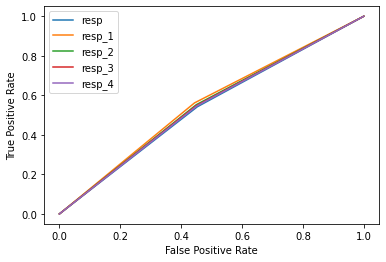

<Figure size 2160x1440 with 0 Axes>

In [27]:
#hide_input
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate scores
ns_auc = roc_auc_score(test_pred[:,3], y_test[:,3])
resp_1 = roc_auc_score(test_pred[:,0], y_test[:,0])
resp_2 = roc_auc_score(test_pred[:,1], y_test[:,1])
resp_3 = roc_auc_score(test_pred[:,2], y_test[:,2])
resp_4 = roc_auc_score(test_pred[:,4], y_test[:,4])
# summarize scores
print('Resp: ROC AUC=%.3f' % (ns_auc))
print('Resp_1: ROC AUC=%.3f' % (resp_1))
print('Resp_2: ROC AUC=%.3f' % (resp_2))
print('Resp_3: ROC AUC=%.3f' % (resp_3))
print('Resp_4: ROC AUC=%.3f' % (resp_4))
# false positive rate, true positive rate
ns_fpr, ns_tpr, _ = roc_curve(test_pred[:,3], y_test[:,3])
fpr_1, tpr_1, _ = roc_curve(test_pred[:,0], y_test[:,0])
fpr_2, tpr_2, _ = roc_curve(test_pred[:,1], y_test[:,1])
fpr_3, tpr_3, _ = roc_curve(test_pred[:,2], y_test[:,2])
fpr_4, tpr_4, _ = roc_curve(test_pred[:,4], y_test[:,4])

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, label='resp')
pyplot.plot(fpr_1, tpr_1, label='resp_1')
pyplot.plot(fpr_2, tpr_2, label='resp_2')
pyplot.plot(fpr_3, tpr_3, label='resp_3')
pyplot.plot(fpr_4, tpr_4, label='resp_4')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.figure(figsize=(30,20))
pyplot.show()

### Result 2 justification


This is actually good! Although one could say that the machine is doing slightly better than me if I was to go to Jane Street and randomly decide to 'action' on trades. <br>



It is important to note that even though we are getting only around ~55% accuracy only, this is actually considered good for trading markets. To explain this, since Jane Market has billions of money, as long as they have a positive return rate, it doesn't matter how much they lose because in the end they will gain more. It is like going to a casino knowing you have more chance of winning than losing. The more time you spend here, the more you will gain out of it!

### Hyper-parameter tuning / Refinement

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 5000
hidden_units = [(150, 150, 150), (100,100,100), (200,200,200)]
dropout_rates = [(0.25, 0.25, 0.25, 0.25), (0.3,0.3,0.3,0.3)]
epochs = 100
num_columns = len(features)
num_labels = 5
#num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate

mlp_CV = KerasClassifier(build_fn=create_mlp, epochs=epochs, batch_size=batch_size, verbose=1)

param_distributions = {'hidden_units':hidden_units, 'learning_rate':[1e-3, 1e-4], 
                  'label_smoothing':[1e-2, 1e-1], 'dropout_rates':dropout_rates,
                      'num_columns': [len(features)], 'num_labels': [5]}

random_cv = RandomizedSearchCV(estimator=mlp_CV, 
                               param_distributions=param_distributions, n_iter=5,
                               n_jobs=-1, cv=3, random_state=42)

random_cv.fit(X_train, y_train, callbacks=[EarlyStopping(patience=10)])#, epochs=200, batch_size=5000)


models = []

models.append(random_cv)

RandomSearch and GridSearch easily runs out of memory..

So from trial and error, I've learned that with learning rate at 1e-3, model overfits quickly around at 10 with batch_size around 5000. However, the model wasn't able to learn much with less than 100 epochs. One solution is to add more layers and perceptrons which is what I did and the result 2 is the result of manual hyper param tuning. Before the model was definetly at around 200 epochs with same learning rate with 5000 batches giving me an accuracy of only 51%. After manual hyperparameter, (running few different param combination by myself) I was able to increase about 3.5% accuracy!

### Conclusion


For my final review and conclusion, check out my [blog post](https://jaekangai.medium.com/things-i-learned-in-the-kaggle-competition-as-a-first-timer-ef3bb905cf94)

Other things to try/explore:
1. Weighted training. We know that sometimes we will encounter 'monster' deals. It is crucial for the Kaggle competition to get these ones correct since these will probably outweight most other trades. So we could make model that focuses more on these heavy trades. (high weight X resp data)
2. Split data and train multiple models. Idea is that we could split the data into two by feature_0 and maybe one model that optimizes the '1's data and another model that optimizes the '-1's data. 
3. Make much more features and explore more data (requires time and big data machines)
4. One interesting thing I learned is that apparently, in financial, it is sometimes good to heavily overfit the model. Something to do with volatile. I've experimented with this and indeed my utility score for the competition went really high when super overfitted with epoches over 200.

### Submission

In [ ]:
th = 0.5

f = np.median
models = models[-3:]

In [30]:
def feature_engineering(df):
    tag_0_group = [9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, 123]
    for col in tag_0_group:
        df['log_'+str(col)] = (df['feature_'+str(col)]-df['feature_'+str(col)].min()+1).transform(np.log)
    return df

In [32]:
#hide_output
import janestreet
#env = janestreet.make_env()
for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features]
        x_tt = feature_engineering(x_tt).values
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        pred = np.mean([model(x_tt, training = False).numpy() for model in models],axis=0)
        pred = f(pred)
        pred_df.action = np.where(pred >= th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)

0it [00:00, ?it/s]


Exception: You can only iterate over `iter_test()` once.

### Reference
[Imputing-missing-values](https://www.kaggle.com/louise2001/imputing-missing-values) <br>
[OWN Jane Street with Keras NN](https://www.kaggle.com/tarlannazarov/own-jane-street-with-keras-nn)